# A Data-Driven Look at Bojack Horseman:

## Sentiment Analysis

Sources
- https://www.kaggle.com/c/word2vec-nlp-tutorial - imdb reviews dataset
- https://www.kaggle.com/kazanova/sentiment140 - tweets dataset
- https://www.springfieldspringfield.co.uk - bojack horseman scripts
- http://www.omdbapi.com/ - bojack horseman imdb ratings
- http://www.racketracer.com/2016/07/06/pandas-in-parallel/ - parallelizing pandas apply
- https://stackoverflow.com/questions/2527892/parsing-a-tweet-to-extract-hashtags-into-an-array-in-python - hashtags regex
- https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression/38119388 - clean tweet regex
- https://github.com/matchado/HashTagSplitter - compound word splitter

In [99]:
# web scraper
from bs4 import BeautifulSoup
# http requests library
import requests
# data manipulator
import pandas as pd
# parallelization
import multiprocessing
from multiprocessing import Pool
# math/linear algebra library
import numpy as np
# regex
import re
# tf-idf weighting scheme
from sklearn.feature_extraction.text import TfidfVectorizer
# logistic and linear regression models
from sklearn.linear_model import LogisticRegression, LinearRegression
# data split one-liner
from sklearn.model_selection import train_test_split
# for api keys saved in environment variables
import os
# plotting charts
import matplotlib.pyplot as plt
# word cloud
from wordcloud import WordCloud, STOPWORDS
# for word cloud image masks
from PIL import Image
# randomness
import random
# for english dictionary
import nltk
from nltk.corpus import words
# shuffle dataset
from sklearn.utils import shuffle
# text similarity calculator
from sklearn.metrics.pairwise import cosine_similarity

In [100]:
# prettify our plots
plt.style.use('ggplot')

In [101]:
# english dictionary
nltk.download('words')
eng_dict = list(set(words.words()))

for alphabet in "bcdefghjklmnopqrstuvwxyz":
    eng_dict.remove(alphabet)

[nltk_data] Downloading package words to /home/tavish/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [102]:
# you will need to get your own key at http://www.omdbapi.com/apikey.aspx
# don't worry it's literally a 10 second process
OMDB_API_KEY = os.environ.get('OMDB_API_KEY')

In [103]:
# set seed to '0' for reproducibility
random.seed(0)

In [227]:
# splitting compound words, commonly found in twitter hashtags
def split_hashtag_to_words(hashtag):
    words = []

    split_posibility = [hashtag[:i] in eng_dict for i in reversed(range(len(hashtag)+1))]
    possible_split_positions = [i for i, x in enumerate(split_posibility) if x == True]

    for split_pos in possible_split_positions:
        split_words = []
        word_1, word_2 = hashtag[:len(hashtag)-split_pos], hashtag[len(hashtag)-split_pos:]

        if word_2 in eng_dict:
            split_words.append(word_1)
            split_words.append(word_2)
            words.append(split_words)
            break
        else:
            another_round = split_hashtag_to_words(word_2)

            if len(another_round) > 0:
                words = words + [[a1] + a2 for a1, a2, in zip([word_1]*len(another_round), another_round)]

    return words

In [228]:
# split dataframe or series and apply function to splits
def parallelized_apply(df, func):
    df_split = np.array_split(df, multiprocessing.cpu_count())
    pool = Pool(multiprocessing.cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [229]:
# Cannot combine 2 diff clean functions as when parallelizing apply we need
# a function which takes in 1 argument and cannot use a lambda function

In [230]:
# clean text in review series
def clean_reviews(series):
    series = series.apply(clean_reviews_helper)
    return series

In [231]:
# clean text in review series
def clean_tweets(series):
    series = series.apply(clean_tweets_helper)
    return series

In [232]:
# remove html tags, ascii chars outside a-z and A-Z range
def clean_reviews_helper(review):
    return re.sub(' +', ' ', re.sub("[^a-zA-Z.]", " ", BeautifulSoup(review, 'html.parser').text))

In [233]:
# split hashtags and remove '#' symbol, mentions and numbers
def clean_tweets_helper(tweet):
    hashtags = re.findall(r"#(\w+)", tweet)
    tags = []
    for hashtag in hashtags:
        tag_words = split_hashtag_to_words(hashtag)
        if len(tag_words) > 0:
            tags.append(' '.join(tag_words[0]))
    if tags:
        tweet = tweet + ' ' + ' '.join(tags)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", tweet).split())

In [234]:
# replace empty strings and whitespace strings with 'NaN' and remove empty rows
def clean_data(dataframe):
    dataframe.replace(r'^\s+$', np.nan, regex=True, inplace = True)
    dataframe.replace('', np.nan, inplace = True)
    dataframe.dropna(how='any', inplace = True)

In [235]:
# display proportions of sentiment labels for dataset
def display_proportions(data):
    labels = data['sentiment'].unique()
    for label in labels:
        print(f"Sentiment {label}: {len(data[data['sentiment'] == label])/len(data)*100}%") 
    print(f'Total entries: {len(data)}')

In [236]:
# display word cloud given an array of word importance scores
def display_wordcloud(scores, img_file):
    mask = np.array(Image.open(img_file))
    wc = WordCloud(background_color = 'white',
                   height = 800, width = 800, max_words = 400, stopwords=set(STOPWORDS), mask = mask)
    cloud = wc.generate_from_frequencies(scores)
    plt.figure()
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [237]:
# generate word importance scores from plain text
def generate_scores_from_text(text, tfidf, w):
    tfidf_matrix =  tfidf.transform([text])
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    # score = abs(word_weight * word's tfidf value)
    scores = [abs(w[x]*tfidf_matrix[0, x]) for x in feature_index]
    word_score_pairs = zip(feature_index, scores)
    feature_names = tfidf.get_feature_names()
    d = {}
    for w, s in [(feature_names[i], s) for (i, s) in word_score_pairs]:
        d[w] = s
    return d

## Setup for Sentiment Analysis

In [129]:
# init tfidf vectorizer
tfidf = TfidfVectorizer(sublinear_tf= True, stop_words= 'english')

In [130]:
# init logisitic regression model
lr = LogisticRegression()

## Approach 1 : Building a Sentiment Classifier using Movie Reviews

In [131]:
# using data from here: https://www.kaggle.com/c/word2vec-nlp-tutorial/data
# it is a dataset of imdb reviews classified into 2 classes: 0 -> :( and 1 -> :)
imdb_data = pd.read_csv('reviews.tsv', delimiter = '\t')
imdb_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [132]:
# clean
clean_data(imdb_data)
# check if there are any entries containing 'NaN'
assert imdb_data.isnull().any(axis = 1).any() == False

In [133]:
# see proportion of sentiments in dataset
display_proportions(imdb_data)

Sentiment 1: 50.0%
Sentiment 0: 50.0%
Total entries: 25000


In [134]:
# clean reviews
imdb_data['review'] = parallelized_apply(imdb_data['review'], clean_reviews)

In [135]:
imdb_data.drop('sentiment', axis=1).shape

(25000, 2)

In [136]:
imdb_data['sentiment'].shape

(25000,)

In [137]:
train, test = train_test_split(imdb_data, test_size = 0.3, stratify = imdb_data['sentiment'])

In [138]:
display_proportions(train)

Sentiment 0: 50.0%
Sentiment 1: 50.0%
Total entries: 17500


In [139]:
display_proportions(test)

Sentiment 1: 50.0%
Sentiment 0: 50.0%
Total entries: 7500


In [140]:
# create np array with tfidf reviews
tfidf_reviews = tfidf.fit_transform(train['review'])
tfidf_reviews.shape

(17500, 63785)

In [141]:
# train the model
lr.fit(tfidf_reviews, train['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [142]:
# test the model
acc = lr.score(tfidf.transform(test['review']), test['sentiment'])
print(f'accuracy : {acc*100:.2f}%')

accuracy : 89.40%


we got an appox. `89 %` accuracy, I think that's not too shabby
but before we apply this model on the bojack horseman data,
we are gonna train the model on ALL the data that we have,
which would allow it to be EVEN MORE accurate

In [143]:
lr.fit(tfidf.fit_transform(imdb_data['review']), imdb_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
# let's do a visual sanity check that our logistic regression is actually picking up
# appropriate positive and negative words

In [145]:
# get logistic regression weights (excluding bias)
weights = lr.coef_.flatten()
weights.shape

(73881,)

In [146]:
tfidf.idf_.shape

(73881,)

In [147]:
# remember that score = weight * tf * idf
# so to see what words are strongest indicators we take the weight * idf product
weights_idf_prod = weights*tfidf.idf_

In [148]:
# 400 largest weights
pos_ind = np.argpartition(weights_idf_prod, -400)[-400:]

In [149]:
# 400 smallest weights
neg_ind = np.argpartition(-1 * weights_idf_prod, -400)[-400:]

In [151]:
# create (word,weight) pairings
positive_pairs = list(zip(np.array(tfidf.get_feature_names())[pos_ind], weights_idf_prod[pos_ind]))
negative_pairs = list(zip(np.array(tfidf.get_feature_names())[neg_ind], -1 * weights_idf_prod[neg_ind]))

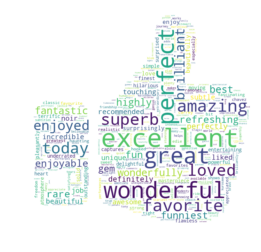

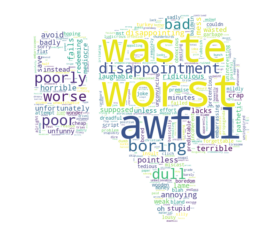

In [152]:
# plot word clouds
d = {}
for w, s in positive_pairs:
    d[w] = s
display_wordcloud(d, 'up.jpg')
d = {}
for w, s in negative_pairs:
    d[w] = s
display_wordcloud(d, 'down.jpg')

We can see that highly positive words such as `great` and `perfect` have very large weights and highley negative words have very low weights such as `bad` and `worst`

This means that positive words would push a text excerpt towards the positive class `1` and negative words will push a text excerpt towards the negative class `0`. Which is exactly how our model should behave 

Notice how the idea of sentiment is skewed to words we often use to describe movies such as `boring` and `enjoyed`

## Approach 2 : Building a Sentiment Classifier using Random Tweets

In [191]:
# Hypothesis: More colloquial language and a more general understanding pos vs neg due to
# a larger number of topics tweeted about (from 1.6m tweets) not just movies

In [192]:
twitter_data = pd.read_csv('tweets.csv', encoding = 'latin1', names = ['sentiment','id','date','flag','user','text'])
twitter_data.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [193]:
twitter_data = shuffle(twitter_data)

In [194]:
twitter_data = twitter_data.head(n=25000)

In [195]:
twitter_data['text'] = parallelized_apply(twitter_data['text'], clean_tweets)

In [196]:
len(twitter_data['text'])

25000

In [197]:
clean_data(twitter_data)

In [198]:
train, test = train_test_split(twitter_data, test_size = 0.3, stratify = twitter_data['sentiment'])

In [199]:
display_proportions(train)

Sentiment 0: 50.06584597766962%
Sentiment 4: 49.934154022330375%
Total entries: 17465


In [200]:
display_proportions(test)

Sentiment 4: 49.93987975951904%
Sentiment 0: 50.06012024048096%
Total entries: 7485


In [201]:
# create np array with tfidf reviews
tfidf_tweets = tfidf.fit_transform(train['text'])
tfidf_tweets.shape

(17465, 19002)

In [202]:
# train the model
lr.fit(tfidf_tweets, train['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [203]:
# test the model
acc = lr.score(tfidf.transform(test['text']), test['sentiment'])
print(f'accuracy : {acc*100:.2f}%')

accuracy : 73.33%


we got an appox. `73 %` accuracy, this is a quite significantly lower than our first dataset
perhaps the tweets are more dissimilar compared to movie reviews

In [204]:
lr.fit(tfidf.fit_transform(twitter_data['text']), twitter_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [205]:
weights = lr.coef_.flatten()
weight_idf_prod = weights*tfidf.idf_

In [206]:
# 400 largest weights
pos_ind = np.argpartition(weight_idf_prod, -400)[-400:]

# 400 smallest weights
neg_ind = np.argpartition(-1 * weight_idf_prod, -400)[-400:]

In [207]:
# create (word,weight) pairings
positive_pairs = list(zip(np.array(tfidf.get_feature_names())[pos_ind], weight_idf_prod[pos_ind]))
negative_pairs = list(zip(np.array(tfidf.get_feature_names())[neg_ind], -1 * weight_idf_prod[neg_ind]))

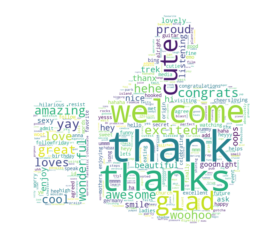

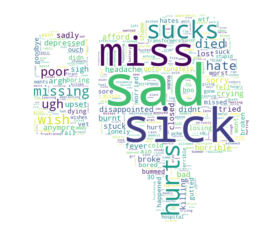

In [208]:
# plot word clouds
d = {}
for w, s in positive_pairs:
    d[w] = s
display_wordcloud(d, 'up.jpg')
d = {}
for w, s in negative_pairs:
    d[w] = s
display_wordcloud(d, 'down.jpg')

It seems that our hypothesis has been confirmed, more geneal words have been understood through the twitter dataset

## Bojack Horseman Analysis

But which dataset should we use? Perhaps we can compare the textual similarity between Bojack Horseman scripts and tweets and movie reviews. The more similar dataset would be a better fit as it would mean that our tfidf mappings would be effective and not be extra sparse

In [209]:
# lists of seasons
seasons = ['0' + str(s) for s in list(range(1,5))]
# list of episodes in each season
season_lengths = [12] * 4 # ignore 13th ep of season 1 (christmas special), as no imdb rating for it
episodes = []

In [210]:
# treat season and episode numbers to comply with url formats for web scraping
# and api requests in the next steps
for s in season_lengths:
    one_season_episodes = []
    for i in range(1, s + 1):
        if i < 10: 
            ep_num = '0' + str(i)
        else:
            ep_num = str(i)
        one_season_episodes.append(ep_num)
    episodes.append(one_season_episodes)
# make sure each season has a corresponding episode number
assert len(seasons) == len(episodes)

In [211]:
scripts = []
ratings = []
# url containing bojack horseman scripts
script_url = 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=bojack-horseman-2014&episode=s{}e{}'
# api endpoint with episode rating info
api = 'http://www.omdbapi.com/?t=Bojack Horseman&Season={}&Episode={}&apikey=' + str(OMDB_API_KEY)
for s in seasons:
    one_season_scripts = []
    one_season_ratings = []
    for e in episodes[int(s)-1]:
        # get and clean script
        response = requests.get(script_url.format(s,e))
        soup = BeautifulSoup(response.content, 'html.parser')
        clean_script = clean_reviews_helper(soup.find('div', class_ = 'scrolling-script-container').text)
        one_season_scripts.append(clean_script)
        # get rating
        response = requests.get(api.format(s,e)).json()
        one_season_ratings.append(response['imdbRating'])
    scripts.append(one_season_scripts)
    ratings.append(one_season_ratings)

In [212]:
flattened_ratings = [rating for season_ratings in ratings for rating in season_ratings]
flattened_ratings = np.array(flattened_ratings, dtype = 'float64')

In [213]:
flattened_scripts = [script for season_scripts in scripts for script in season_scripts]

In [214]:
len(twitter_data['text'])

24950

In [215]:
tfidf.fit_transform(twitter_data['text'])

<24950x23793 sparse matrix of type '<class 'numpy.float64'>'
	with 158220 stored elements in Compressed Sparse Row format>

In [216]:
cosine_similarity(tfidf.transform([' '.join(flattened_scripts)]), tfidf.transform([twitter_data['text'].str.cat()]))

array([[0.64444159]])

In [217]:
tfidf.fit_transform(imdb_data['review'])

<25000x73881 sparse matrix of type '<class 'numpy.float64'>'
	with 2206008 stored elements in Compressed Sparse Row format>

In [218]:
cosine_similarity(tfidf.transform([' '.join(flattened_scripts)]), tfidf.transform([imdb_data['review'].str.cat()]))

array([[0.44820372]])

This performed more poorly, so let's stick to our tweets

In [220]:
tfidf.fit_transform(twitter_data['text'])

<24950x23793 sparse matrix of type '<class 'numpy.float64'>'
	with 158220 stored elements in Compressed Sparse Row format>

In [221]:
# we will use the probability that a script belongs to class '0', the negative class,
# as a negativity score. Min negativity is 0 and max negativity is 1
sentiments = []
for s in scripts:
    sentiments.append(lr.predict_proba(tfidf.transform(s))[:,0])

In [223]:
# convert all values into a 1d array
flattened_sentiments =  [sentiment for season_sentiments in sentiments for sentiment in season_sentiments]
flattened_sentiments = np.array(flattened_sentiments, dtype = 'float64')

r-squared: 0.01875551160913258


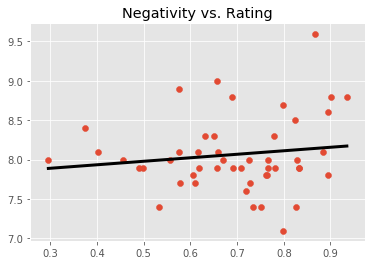

In [224]:
# plotting negativity vs. rating
linereg = LinearRegression()
linereg.fit(flattened_sentiments.reshape(-1,1), flattened_ratings)
x_min = flattened_sentiments.min()
y_min = linereg.predict(x_min.reshape(1,-1))
x_max = flattened_sentiments.max()
y_max = linereg.predict(x_max.reshape(1,-1))
plt.plot([x_min, x_max], [y_min, y_max], color = 'black', linewidth = 3)
plt.scatter(flattened_sentiments, flattened_ratings)
plt.title('Negativity vs. Rating')
print(f"r-squared: {linereg.score(np.array(flattened_sentiments, dtype = 'float64').reshape(-1,1), \
            np.array(flattened_ratings, dtype = 'float64'))}")

We can see that there is a slight positive linear correlation between the negativity of an episode and its rating

r-squared: 0.17894953570358263


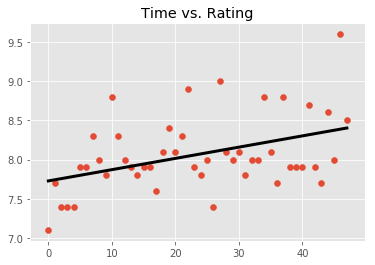

In [249]:
linereg = LinearRegression()
linereg.fit(np.arange(len(flattened_ratings)).reshape(-1,1), flattened_ratings)
x_min = np.arange(len(flattened_ratings)).min()
y_min = linereg.predict(x_min.reshape(1,-1))
x_max = np.arange(len(flattened_ratings)).max()
y_max = linereg.predict(x_max.reshape(1,-1))
plt.plot([x_min, x_max], [y_min, y_max], color = 'black', linewidth = 3)
plt.scatter(np.arange(len(flattened_ratings)), flattened_ratings)
plt.title('Time vs. Rating')
print(f"r-squared: {linereg.score(np.arange(len(flattened_ratings)).reshape(-1,1), \
            np.array(flattened_ratings, dtype = 'float64'))}")

In [ ]:
# stronger positive correlation between time and rating

r-squared: 0.019416938063364864


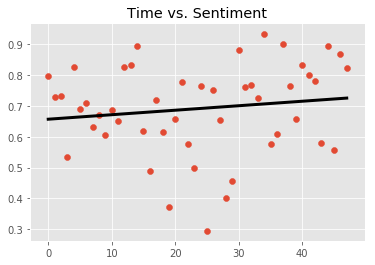

In [251]:
linereg = LinearRegression()
linereg.fit(np.arange(len(flattened_sentiments)).reshape(-1,1), flattened_sentiments)
x_min = np.arange(len(flattened_sentiments)).min()
y_min = linereg.predict(x_min.reshape(1,-1))
x_max = np.arange(len(flattened_sentiments)).max()
y_max = linereg.predict(x_max.reshape(1,-1))
plt.plot([x_min, x_max], [y_min, y_max], color = 'black', linewidth = 3)
plt.scatter(np.arange(len(flattened_sentiments)), flattened_sentiments)
plt.title('Time vs. Sentiment')
print(f"r-squared: {linereg.score(np.arange(len(flattened_sentiments)).reshape(-1,1), \
            np.array(flattened_sentiments, dtype = 'float64'))}")

In [ ]:
# slight positive correlation between time and sentiment

In [225]:
# Let's see if our tfidf vectors are even properly representing
# positivity and negativity through wordclouds

Most Negative 0.94 -> Season: 3, Episode: 11


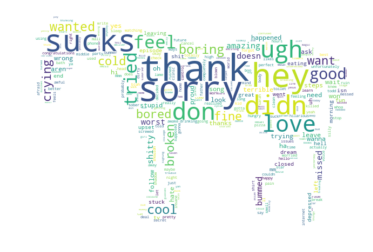

Most Positive 0.30 -> Season: 3, Episode: 2


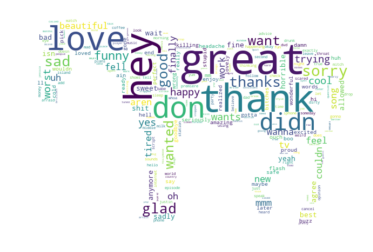

In [238]:
most_negative_ix = np.argmax(flattened_sentiments)
print(f'Most Negative {(np.max(flattened_sentiments)):.2f} -> Season: {most_negative_ix//12 + 1}, Episode: {most_negative_ix % 12 + 1}')
freq = generate_scores_from_text(scripts[most_negative_ix//12][most_negative_ix % 12], tfidf, weights)
display_wordcloud(freq, 'horse.png')
most_positive_ix = np.argmin(flattened_sentiments)
print(f'Most Positive {(np.min(flattened_sentiments)):.2f} -> Season: {most_positive_ix//12 + 1}, Episode: {most_positive_ix % 12 + 1}')
freq = generate_scores_from_text(scripts[most_positive_ix//12][most_positive_ix % 12], tfidf, weights)
display_wordcloud(freq, 'horse.png')